# Detecting Multimodal AUC distributions in HNSCC 

We currently assign sensitivities by tail-assignment, however, there may be cases with distinctive multimodal distributions that are indicative of different response models. 

We'll begin by testing the method on beatAML data where we have much greater number of observations, and therefore more well defined distributions. 

$$ p(x) = \frac{1}{\sqrt{ 2 \pi \sigma^2 }} e^{ - \frac{ (x - \mu)^2 } {2 \sigma^2} } $$

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd 
import numpy as np
from sklearn.mixture import GMM
import seaborn as sbn
from matplotlib import pyplot as plt
import warnings

# ------ for mut models ---------
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import statsmodels.api as sm
from sklearn import metrics

warnings.filterwarnings("ignore")

In [3]:
aml_aucs = pd.read_csv('./../data/beatAML_aucs.csv')[['inhibitor','lab_id','auc']].drop_duplicates()

#aml_aucs = pd.read_csv('./../data/beatAML_AUCs_subset.csv')

In [4]:
aml_aucs.head()

,inhibitor,lab_id,auc
0,17-AAG (Tanespimycin),12-00211,225.918025
7,17-AAG (Tanespimycin),12-00219,135.264409
14,17-AAG (Tanespimycin),12-00258,164.561227
21,17-AAG (Tanespimycin),12-00262,111.555971
28,17-AAG (Tanespimycin),12-00268,226.805281


In [5]:
def add_normal_plot(mu, s, weight, c, ax, auc_max=300): 
    '''
    mu = mean
    s = standard deviation
    ax = matplotlib axes to add to 
    c = color {[r b g c y ...]} <str> 
    '''
    
    x = np.arange(0, auc_max, 1)
    y = (1/(2*np.pi*s**2)**(0.5))*np.exp( - (x-mu)**2/(2*s**2) ) * weight
    
    ax = ax.plot(x,y, color=c, label='mean: %.1f, std: %.1f' %(mu, s))

def get_color():
    '''
    
    '''
    for c in ['r','b','g','c','y']: 
        yield c
    

In [6]:
gen = get_color()
gen.__next__()

'r'

In [7]:
def test_multimodal_fits(X, ntests=10, kmax=5, plot=True, inhib=None, override_k=False): 
    '''
    
    '''
    
    res = {x:[] for x in ['k', 'aic', 'bic']}
    for k in range(1,kmax): 
        for i in range(ntests): 
            
            #print('k: %d' %k)
            gmm = GMM(n_components=k, n_init=1)
            gmm.fit(X)
            res['k'].append( k )
            res['aic'].append( gmm.aic(X) )
            res['bic'].append( gmm.bic(X) )
            
    res = pd.DataFrame( res )
    
    best_k = res[res.bic == np.min(res.bic)].k.unique()[0] if not override_k else override_k
    gmm_best = GMM(n_components=best_k,n_init=20) 
    gmm_best.fit(X)
    P = gmm_best.predict(X)
    
    if plot:         
        nbins = 50
        bin_ = np.arange(0,np.max(X),np.max(X)/nbins)
        
        scalar_to_make_pretty = 0.25 # since our fitted Gaussians are normalized to their weights, they appear smaller
        weights_ = scalar_to_make_pretty/len(X)
        
        f, axs = plt.subplots(1,3,figsize=(15,5)) 
        sbn.distplot(X, bins=bin_, ax=axs[0]).set_title('AUC distribution')
        sbn.scatterplot(x='k', y='bic', alpha=0.3, data=res, ax=axs[1]).set_title('BIC vs K')
        
        clas = 0
        for weight, mean, covars, c in zip(gmm_best.weights_, gmm_best.means_, gmm_best.covars_, get_color()): 
            sbn.distplot(X[P==clas], bins=bin_, kde=False, color=c, ax=axs[2], label='AUC', hist_kws={'weights': [weights_]*len(X[P==clas])})
            add_normal_plot(mean[0], (covars[0])**0.5, weight, c, axs[2], auc_max=np.max(X))
            clas+=1
        
        axs[2].set_title('Optimal GMM fit')
        
        plt.legend()
        plt.suptitle(inhib)
        
        print('Number of assays (aucs): %d' %len(X))
        print('Optimal K: %d [BIC=%.1f]' %(best_k, np.min(res.bic)))
        print('GMM fit:\n\tMixture Weights: %r\n\tMeans: %r\n\tVariances: %r' %(gmm_best.weights_.ravel(), gmm_best.means_.ravel(), gmm_best.covars_.ravel()))
        print('Class counts: %r' %['class %d: %d' %(cl, len(X[P==cl])) for cl in list(set(P))])
        
        plt.show()
        
    return P


------------------------------------------------
Inhibitor:  Axitinib (AG-013736)
------------------------------------------------
Number of assays (aucs): 489
Optimal K: 1 [BIC=5142.2]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([196.08068388])
	Variances: array([2105.86622831])
Class counts: ['class 0: 489']


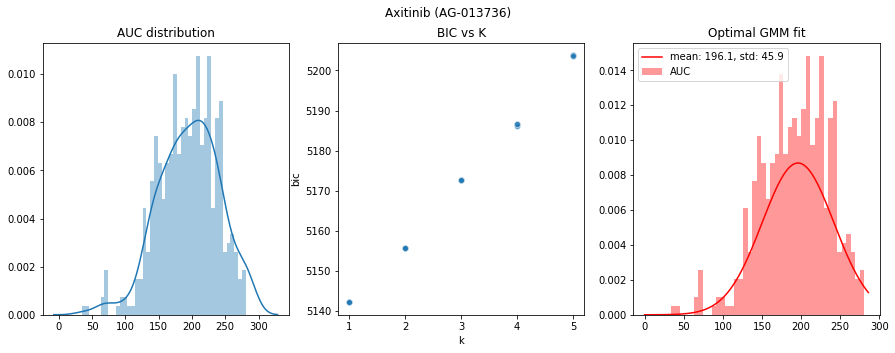

------------------------------------------------
Inhibitor:  Crizotinib (PF-2341066)
------------------------------------------------
Number of assays (aucs): 497
Optimal K: 1 [BIC=5065.6]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([204.51331279])
	Variances: array([1524.50444563])
Class counts: ['class 0: 497']


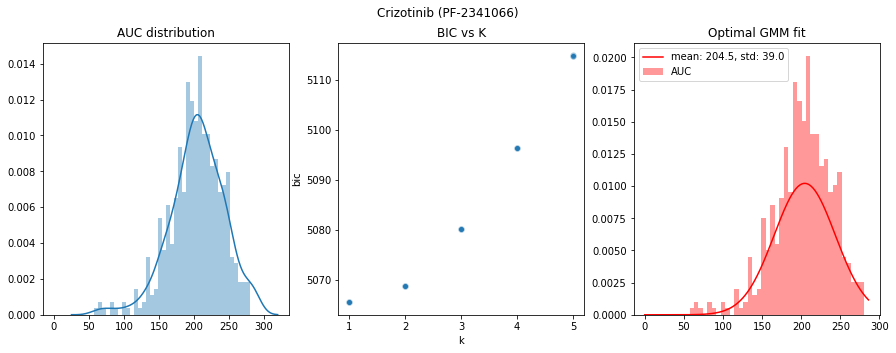

------------------------------------------------
Inhibitor:  Dasatinib
------------------------------------------------
Number of assays (aucs): 500
Optimal K: 2 [BIC=5491.2]
GMM fit:
	Mixture Weights: array([0.53217975, 0.46782025])
	Means: array([217.77686359, 123.55335351])
	Variances: array([1257.28478297, 1388.06017329])
Class counts: ['class 0: 276', 'class 1: 224']


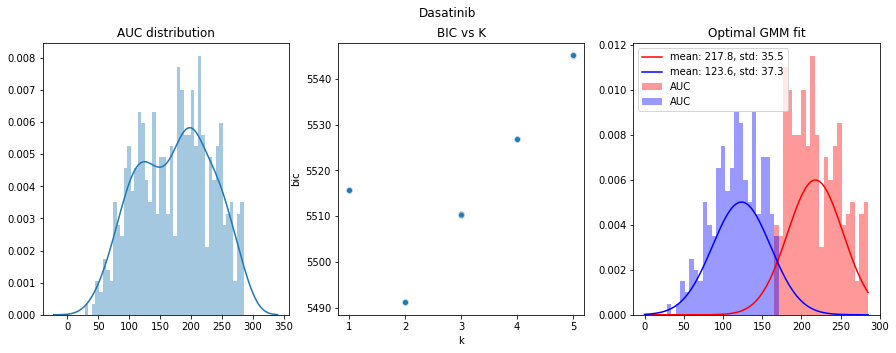

------------------------------------------------
Inhibitor:  Erlotinib
------------------------------------------------
Number of assays (aucs): 494
Optimal K: 2 [BIC=4859.8]
GMM fit:
	Mixture Weights: array([0.61873948, 0.38126052])
	Means: array([245.28723167, 206.3491596 ])
	Variances: array([ 454.2151368 , 1366.94034476])
Class counts: ['class 0: 360', 'class 1: 134']


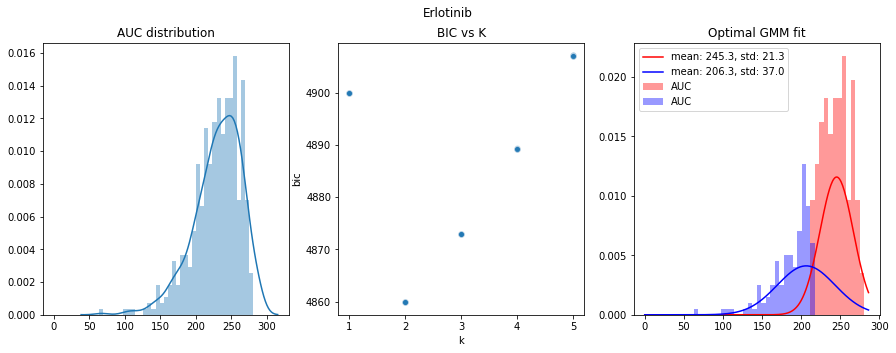

------------------------------------------------
Inhibitor:  Gefitinib
------------------------------------------------
Number of assays (aucs): 492
Optimal K: 2 [BIC=4781.7]
GMM fit:
	Mixture Weights: array([0.66870742, 0.33129258])
	Means: array([253.3594795 , 216.04175397])
	Variances: array([ 403.86181731, 1573.84847907])
Class counts: ['class 0: 390', 'class 1: 102']


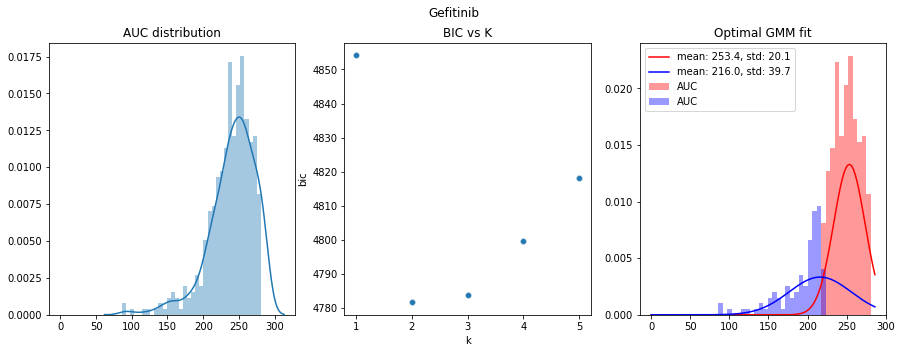

------------------------------------------------
Inhibitor:  Imatinib
------------------------------------------------
Number of assays (aucs): 511
Optimal K: 3 [BIC=5165.5]
GMM fit:
	Mixture Weights: array([0.43325213, 0.43545984, 0.13128803])
	Means: array([227.41765714, 252.6459565 , 172.61882634])
	Variances: array([ 881.99645221,  470.01793071, 3189.19280153])
Class counts: ['class 0: 196', 'class 1: 275', 'class 2: 40']


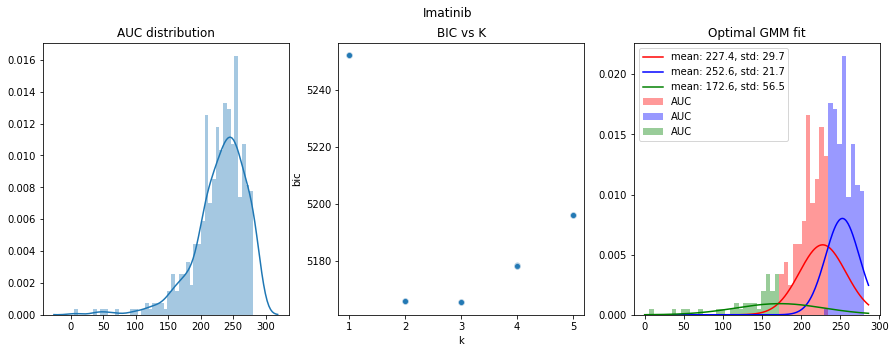

------------------------------------------------
Inhibitor:  Lapatinib
------------------------------------------------
Number of assays (aucs): 485
Optimal K: 2 [BIC=4735.0]
GMM fit:
	Mixture Weights: array([0.37159515, 0.62840485])
	Means: array([212.13786003, 243.08928529])
	Variances: array([1530.34760838,  455.4886863 ])
Class counts: ['class 0: 101', 'class 1: 384']


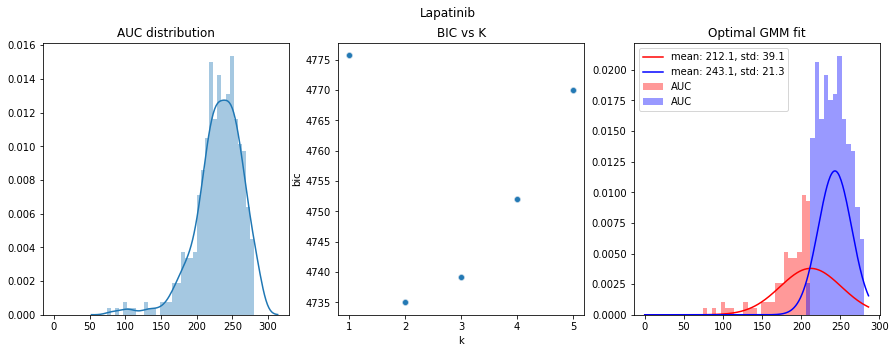

------------------------------------------------
Inhibitor:  Nilotinib
------------------------------------------------
Number of assays (aucs): 495
Optimal K: 2 [BIC=5019.4]
GMM fit:
	Mixture Weights: array([0.50233536, 0.49766464])
	Means: array([199.7455403 , 255.40790252])
	Variances: array([1001.10418362,  462.24300534])
Class counts: ['class 0: 237', 'class 1: 258']


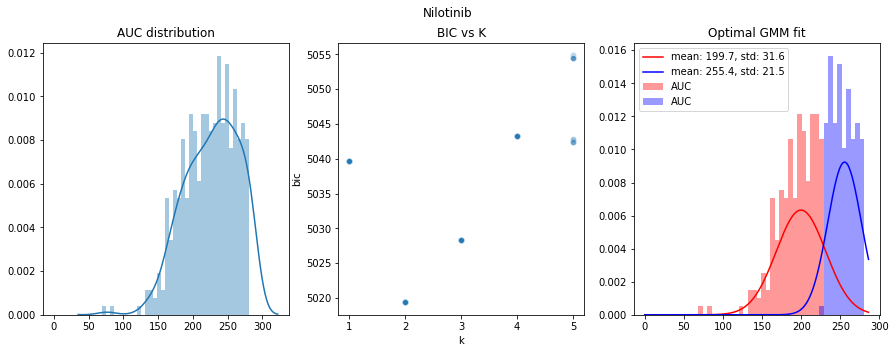

------------------------------------------------
Inhibitor:  Pazopanib (GW786034)
------------------------------------------------
Number of assays (aucs): 486
Optimal K: 2 [BIC=5087.4]
GMM fit:
	Mixture Weights: array([0.56246155, 0.43753845])
	Means: array([237.73450149, 188.62149669])
	Variances: array([ 926.376757  , 2163.34416825])
Class counts: ['class 0: 324', 'class 1: 162']


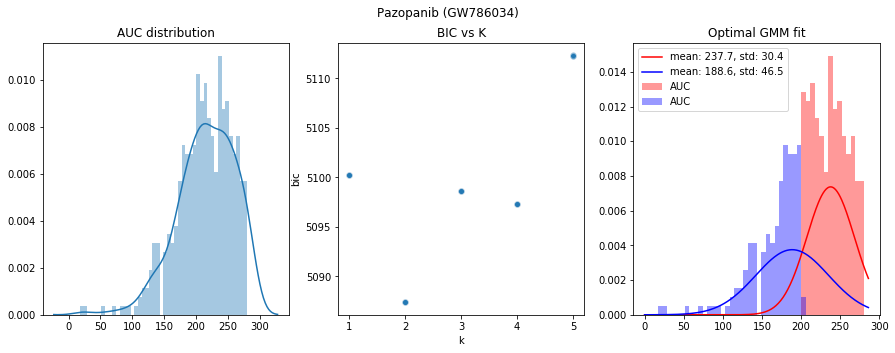

------------------------------------------------
Inhibitor:  Ponatinib (AP24534)
------------------------------------------------
Number of assays (aucs): 460
Optimal K: 2 [BIC=5002.3]
GMM fit:
	Mixture Weights: array([0.5210963, 0.4789037])
	Means: array([113.26869384, 193.48173313])
	Variances: array([1281.09410219, 1604.4604425 ])
Class counts: ['class 0: 248', 'class 1: 212']


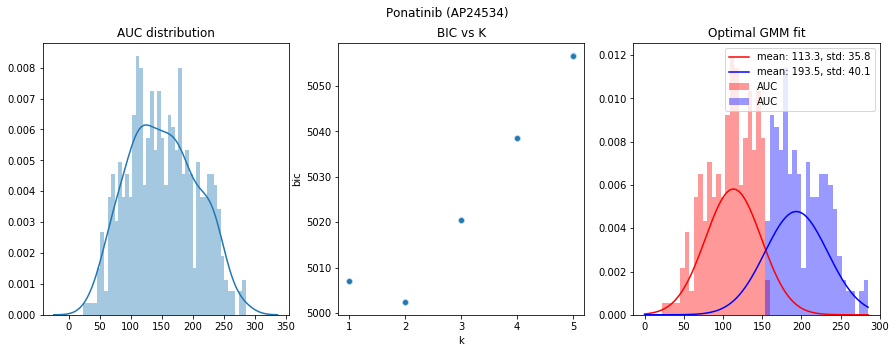

------------------------------------------------
Inhibitor:  Rapamycin
------------------------------------------------
Number of assays (aucs): 478
Optimal K: 1 [BIC=5206.2]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([175.98806926])
	Variances: array([3065.14456621])
Class counts: ['class 0: 478']


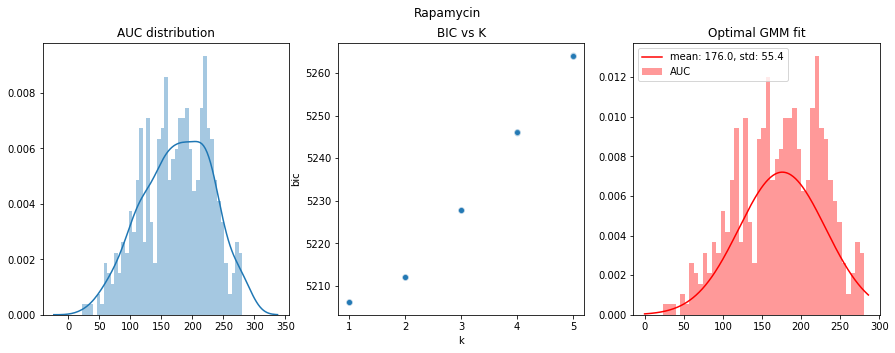

------------------------------------------------
Inhibitor:  Ruxolitinib (INCB018424)
------------------------------------------------
Number of assays (aucs): 475
Optimal K: 3 [BIC=4700.5]
GMM fit:
	Mixture Weights: array([0.44450288, 0.47605634, 0.07944077])
	Means: array([258.90372332, 220.15762164, 174.7215596 ])
	Variances: array([ 339.18182279,  509.02343414, 2042.03146949])
Class counts: ['class 0: 222', 'class 1: 232', 'class 2: 21']


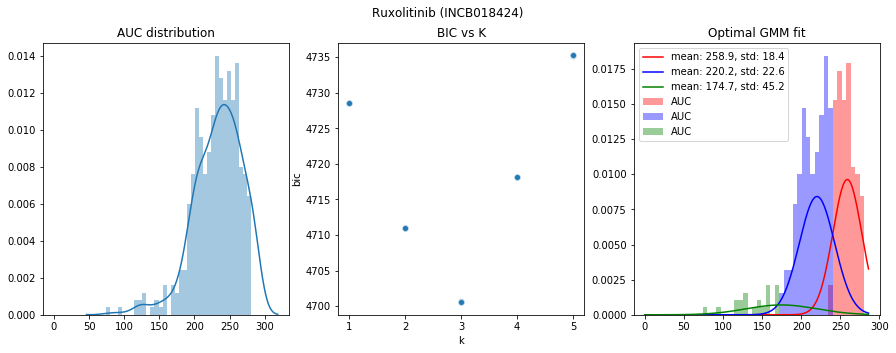

------------------------------------------------
Inhibitor:  Sorafenib
------------------------------------------------
Number of assays (aucs): 505
Optimal K: 2 [BIC=5406.4]
GMM fit:
	Mixture Weights: array([0.42476075, 0.57523925])
	Means: array([160.43097496, 220.70232329])
	Variances: array([2577.01244736, 1141.4331894 ])
Class counts: ['class 0: 173', 'class 1: 332']


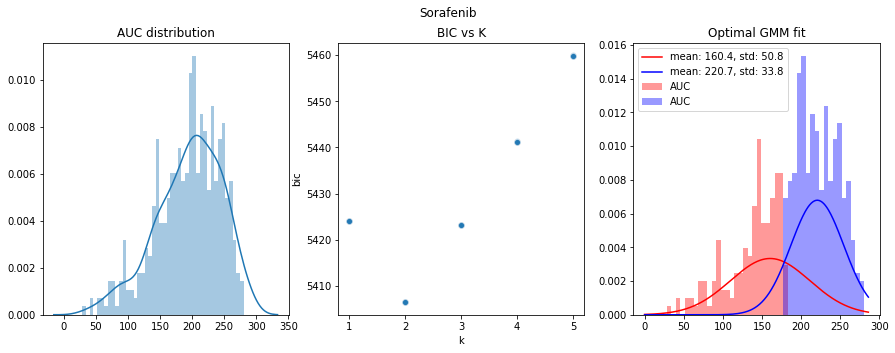

------------------------------------------------
Inhibitor:  Sunitinib
------------------------------------------------
Number of assays (aucs): 501
Optimal K: 2 [BIC=5264.8]
GMM fit:
	Mixture Weights: array([0.43124777, 0.56875223])
	Means: array([170.94741204, 225.67490839])
	Variances: array([2018.09015565,  950.86260094])
Class counts: ['class 0: 179', 'class 1: 322']


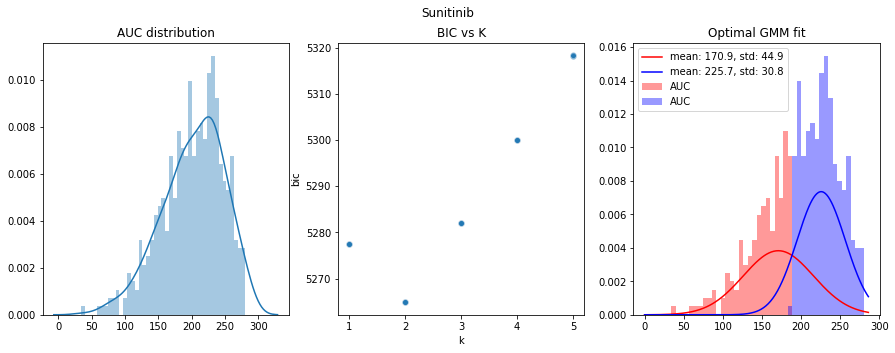

------------------------------------------------
Inhibitor:  Trametinib (GSK1120212)
------------------------------------------------
Number of assays (aucs): 454
Optimal K: 2 [BIC=5063.9]
GMM fit:
	Mixture Weights: array([0.46362194, 0.53637806])
	Means: array([184.25571516,  86.55306617])
	Variances: array([2471.94396084, 1299.10847577])
Class counts: ['class 0: 203', 'class 1: 251']


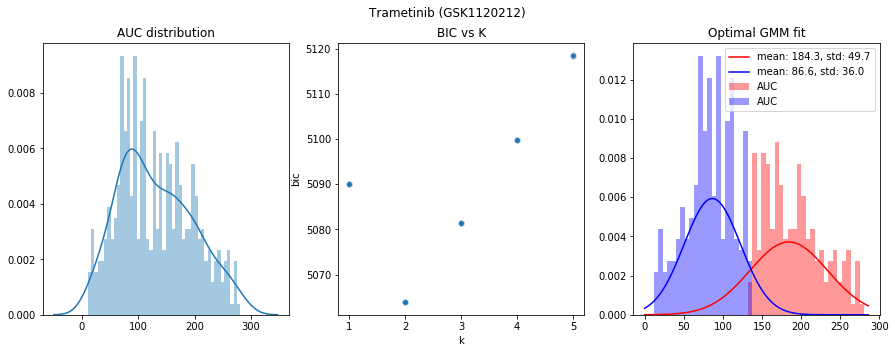

------------------------------------------------
Inhibitor:  Vandetanib (ZD6474)
------------------------------------------------
Number of assays (aucs): 491
Optimal K: 5 [BIC=5054.9]
GMM fit:
	Mixture Weights: array([0.23685074, 0.24542699, 0.01871138, 0.16772781, 0.33128308])
	Means: array([214.26303454, 273.17534553,  66.10450026, 182.02665389,
       234.85040802])
	Variances: array([ 840.16807373,  113.10459821, 1179.2313362 , 1067.74956401,
        291.61569295])
Class counts: ['class 0: 69', 'class 1: 133', 'class 2: 9', 'class 3: 69', 'class 4: 211']


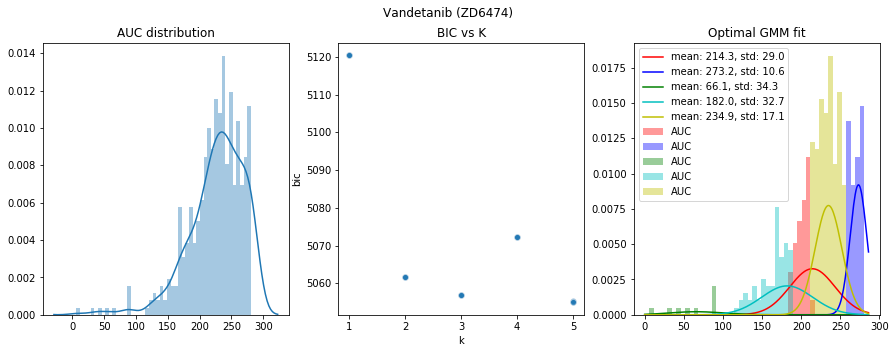

In [8]:
for inhib in aml_aucs.inhibitor.unique(): 
    inhib_dat = aml_aucs[aml_aucs.inhibitor == inhib]
    if inhib_dat.shape[0] > 450: 
        print('------------------------------------------------')
        print('Inhibitor:  %s' %inhib)
        print('------------------------------------------------')
        AUCS =  inhib_dat.auc.values.reshape(-1,1)
        test_multimodal_fits(AUCS, ntests=10, kmax=6, inhib=inhib, plot=True)
    

# Save subset of okay'd data

In [9]:
okay_data = ['YM-155', 'Vandetanib (ZD6474)', 'Trametinib (GSK1120212)', 'Sunitinib','Sorafenib', 'Selumetinib (AZD6244)', 'Nilotinib', 'JAK Inhibitor I', 'Pazopanib (GW786034)', 'Elesclomol', 'Dasatinib']

dat = aml_aucs[aml_aucs.inhibitor.isin(okay_data)]
dat.to_csv('./../data/beatAML_AUCs_subset.csv')

# Test HNSCC distribution

The next step is to ask, can we model these drug responses across cancer types? As in, are the distributions that are well defined by the beatAML similarly define the HNSCC distribution? 

We will try to test this by setting our null hypothesis as: 

Let X be the underlying set distribution such that: 
$$ AUC_{beatAML} \in X $$  

$$ H_0: AUC_{HNSCC} \in X $$ 
and 
$$ H_1: AUC_{HNSCC} \notin X $$ 

We will use permutation testing, and reject cases where `alpha=0.05`. 


In [10]:
HNSCC_all = pd.read_csv('./../data/HNSCC_all_functional_data.csv')
HNSCC_auc = HNSCC_all[['lab_id','inhibitor','auc','call']].drop_duplicates()
HNSCC_auc.head()

,lab_id,inhibitor,auc,call
0,10004,JQ1;BEZ235,1.044426,int
1,10004,Lucitanib,2.809226,res
2,10004,Resveratrol,2.794546,int
3,10004,Pelitinib (EKB-569),1.221167,sens
4,10004,Bicalutamide,2.742498,int


In [11]:
shared_drugs = list( set(HNSCC_all.inhibitor) & set(aml_aucs.inhibitor) )

shared_drugs

['MK-2206',
 'Canertinib (CI-1033)',
 'Flavopiridol',
 'GDC-0941',
 'BI-2536',
 'Panobinostat',
 'Neratinib (HKI-272)',
 'Lestaurtinib (CEP-701)',
 'YM-155',
 'Taselisib (GDC-0032)',
 'INK-128',
 'Selinexor',
 'Selumetinib (AZD6244)',
 'Bortezomib (Velcade)',
 'STO609',
 'JNJ-28312141',
 'Nilotinib',
 'Lenvatinib',
 'PI-103',
 'PP242',
 'Tozasertib (VX-680)',
 'MGCD-265',
 'A-674563',
 'TAK-659',
 'Gefitinib',
 'Erlotinib',
 'Sorafenib',
 'Lenalidomide',
 'Entrectinib',
 'Lapatinib',
 'JQ1',
 '17-AAG (Tanespimycin)',
 'Imatinib',
 'Rapamycin',
 'GSK-1838705A',
 'SCH-772984',
 'Elesclomol',
 'Pelitinib (EKB-569)',
 'MLN120B',
 'BEZ235',
 'NVP-ADW742']

In [319]:
def permutation_test(x, y, n=1e5, verbose=True, return_prob=True, alpha=0.05):
    '''
    two tailed permutation test to see if y is apart of same model as x 
    
    returns the probability that y is not drawn from the same underlying model (or True if prob > 0.05 and return_prob=True)
    
    if pval > alpha -> x,y may not have been drawn from same distribution (alpha probability not drawn)
    
    H0: Distributions are the same 
    H1: the distributions are the not the same
    
    but we want 95% confidence that the distributions are the same... so, 
    '''
    x = x.ravel()
    y = y.ravel()
    z = np.append(x,y)
    
    T = np.abs( np.mean(x) - np.mean(y) )
    permutation_means = []

    for i in range(int(n)):
        if (i % 333 == 0) and verbose: print('Running permutations...[%.2f%%]' %(i/n*100), end='\r')
        perms = np.random.permutation(z)
        perm_y = perms[:len(y)]
        perm_x = perms[len(y):]
        permutation_means.append( np.abs(np.mean(perm_y) - np.mean(perm_x)) )
    print()
    
    print(np.sum(1* np.array(permutation_means) > T))
    print(delta_mean)
    pval = np.sum( 1*np.array(permutation_means) > T ) / len( permutation_means )
    return pval if return_prob else pval >= alpha

def test_distribution_similarity(aml, hnscc, inhib=None, verbose=True, perms=1e5): 
    '''
    
    '''
    if verbose: print('---------------------------------------------------------')
    if verbose: print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
    if verbose: print(inhib)
    if verbose: print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
    if verbose: print('---------------------------------------------------------')
    if verbose: print()
        
    print('HNSCC assays:    %d' %hnscc.shape[0])
    print('AML assays:      %d' %aml.shape[0])
        
    test_multimodal_fits(aml, ntests=10, kmax=6, inhib=inhib, plot=True)
    test_multimodal_fits(hnscc, ntests=10, kmax=6, inhib=inhib, plot=True)
    test_multimodal_fits(np.append(aml.ravel(),hnscc.ravel()).reshape(-1,1), ntests=10, kmax=6, inhib=inhib + ' hnscc-aml', plot=True)
    
    nbins=50
    bin_ = np.arange(0,300,300/nbins)

    plt.figure()
    plt.hist(aml_,color='blue',label='AML_AUC',normed=True,alpha=0.4,bins=bin_)
    plt.hist(hnscc_,color='red',label='HNSCC_AUC',normed=True,alpha=0.4,bins=bin_)
    plt.legend()
    plt.show()
    
    pval = permutation_test(aml_, hnscc_, n=perms, verbose=True, return_prob=True)
    if verbose: print('Dasatinib permutation test p-value: %f' %pval)
    

---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Rapamycin
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      478
Number of assays (aucs): 478
Optimal K: 1 [BIC=5206.2]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 175.98806926])
	Variances: array([ 3065.14456621])
Class counts: ['class 0: 478']


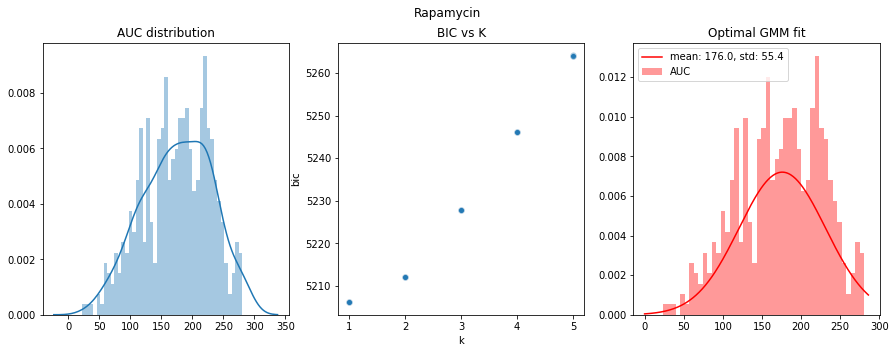

Number of assays (aucs): 17
Optimal K: 1 [BIC=188.8]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 212.46846562])
	Variances: array([ 2787.11227825])
Class counts: ['class 0: 17']


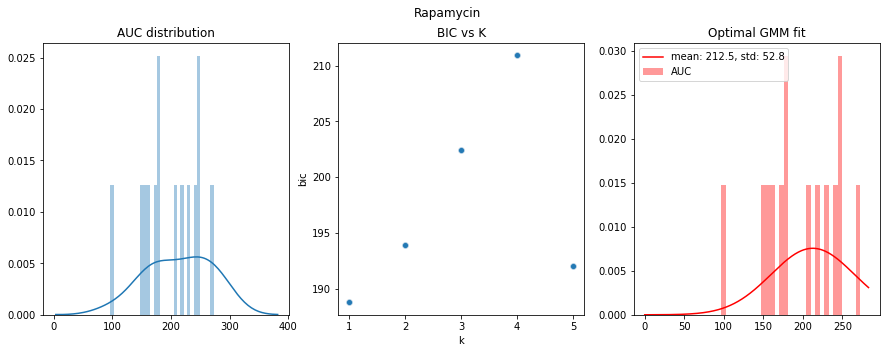

Number of assays (aucs): 495
Optimal K: 1 [BIC=5396.5]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 177.24093136])
	Variances: array([ 3099.73122504])
Class counts: ['class 0: 495']


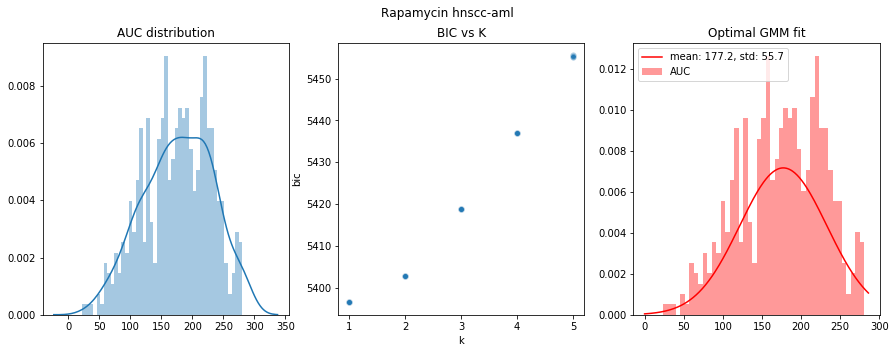

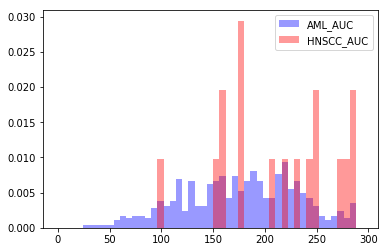

Running permutations...[100.00%]
7706
36.4803963619
Dasatinib permutation test p-value: 0.007706
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
PP242
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      432
Number of assays (aucs): 432
Optimal K: 1 [BIC=4575.4]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 139.92493152])
	Variances: array([ 2264.95055139])
Class counts: ['class 0: 432']


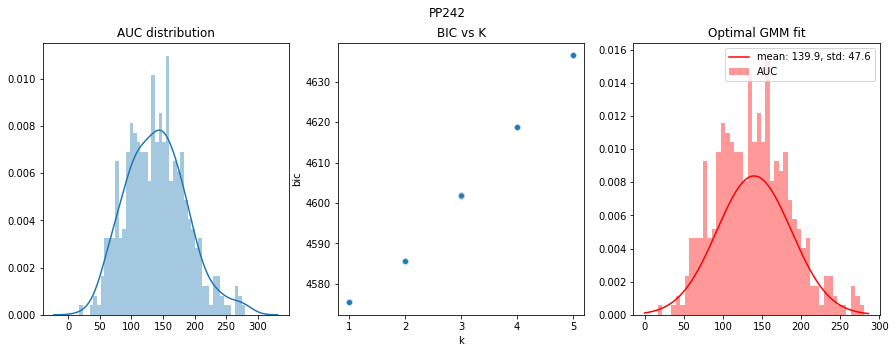

Number of assays (aucs): 17
Optimal K: 1 [BIC=175.0]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 199.8533003])
	Variances: array([ 1241.56981283])
Class counts: ['class 0: 17']


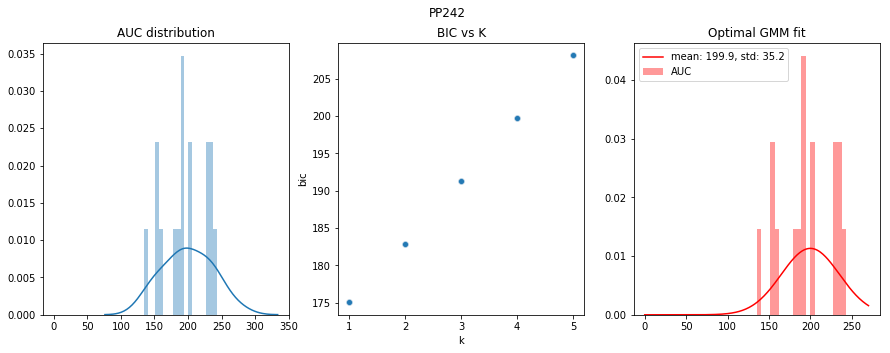

Number of assays (aucs): 449
Optimal K: 1 [BIC=4773.0]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 142.19393434])
	Variances: array([ 2357.03266083])
Class counts: ['class 0: 449']


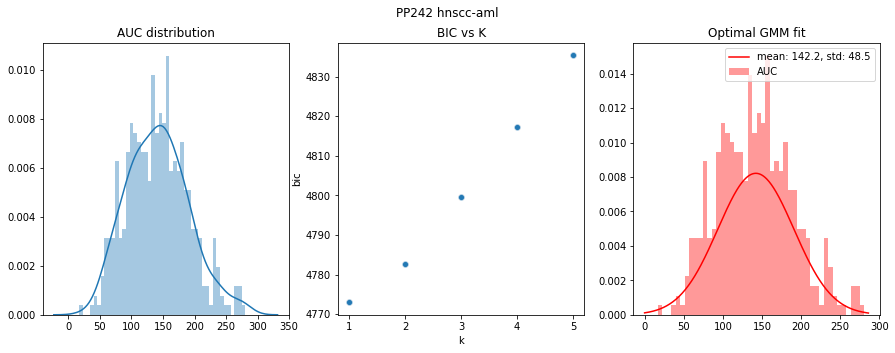

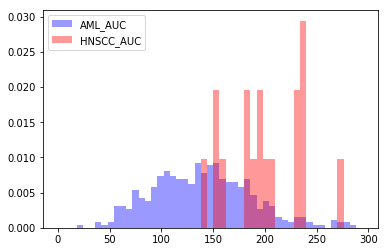

Running permutations...[100.00%]
1
59.9283687823
Dasatinib permutation test p-value: 0.000001
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Panobinostat
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      208
Number of assays (aucs): 208
Optimal K: 2 [BIC=2279.7]
GMM fit:
	Mixture Weights: array([ 0.73669121,  0.26330879])
	Means: array([  60.96557798,  182.07599155])
	Variances: array([  932.05620099,  4012.50516911])
Class counts: ['class 0: 160', 'class 1: 48']


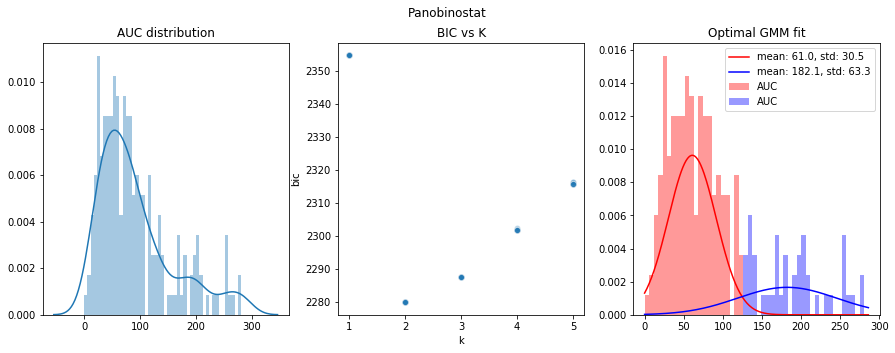

Number of assays (aucs): 17
Optimal K: 1 [BIC=187.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 123.02367096])
	Variances: array([ 2528.13453794])
Class counts: ['class 0: 17']


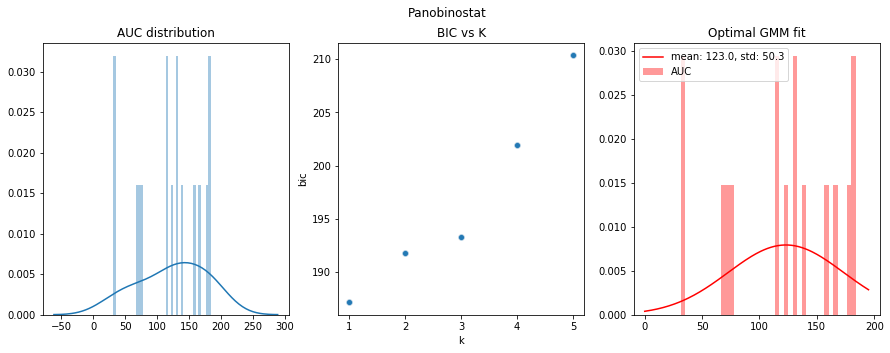

Number of assays (aucs): 225
Optimal K: 2 [BIC=2476.5]
GMM fit:
	Mixture Weights: array([ 0.67851334,  0.32148666])
	Means: array([  60.62082131,  167.97707387])
	Variances: array([  919.90057886,  4224.29257575])
Class counts: ['class 0: 163', 'class 1: 62']


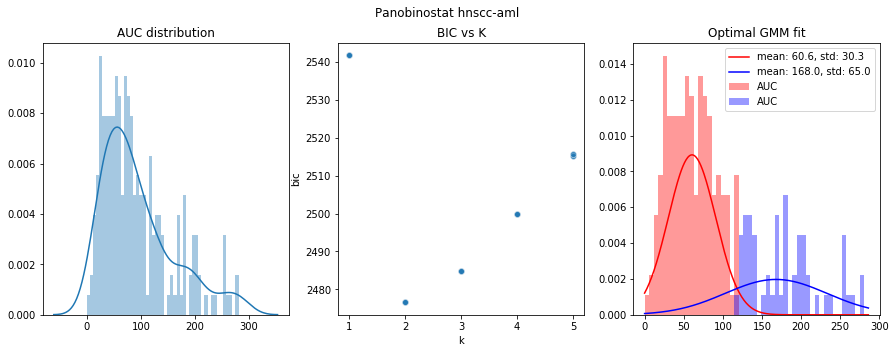

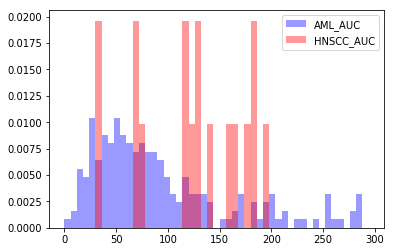

Running permutations...[100.00%]
73097
30.1686561583
Dasatinib permutation test p-value: 0.073097
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Tozasertib (VX-680)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      436
Number of assays (aucs): 436
Optimal K: 2 [BIC=4440.2]
GMM fit:
	Mixture Weights: array([ 0.66291631,  0.33708369])
	Means: array([ 227.08966462,  184.24468239])
	Variances: array([  718.34101867,  2144.77726346])
Class counts: ['class 0: 352', 'class 1: 84']


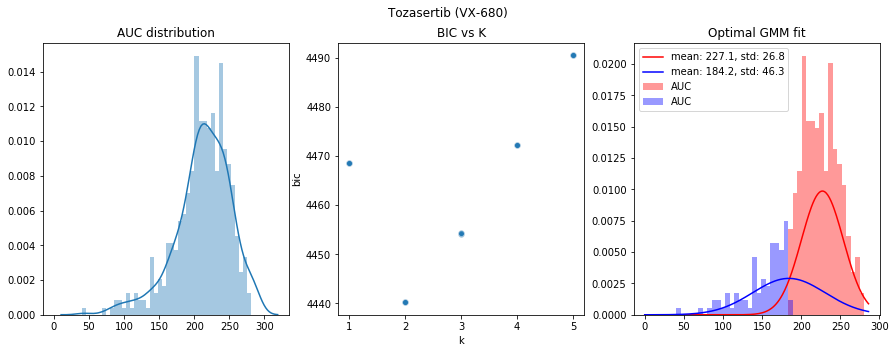

Number of assays (aucs): 17
Optimal K: 1 [BIC=167.2]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 236.30828056])
	Variances: array([ 783.72554039])
Class counts: ['class 0: 17']


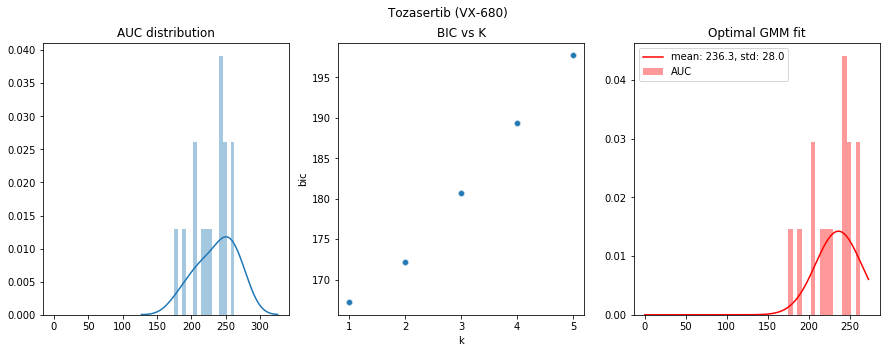

Number of assays (aucs): 453
Optimal K: 2 [BIC=4609.7]
GMM fit:
	Mixture Weights: array([ 0.66176668,  0.33823332])
	Means: array([ 227.95382197,  185.32477745])
	Variances: array([  717.04548478,  2120.82972573])
Class counts: ['class 0: 364', 'class 1: 89']


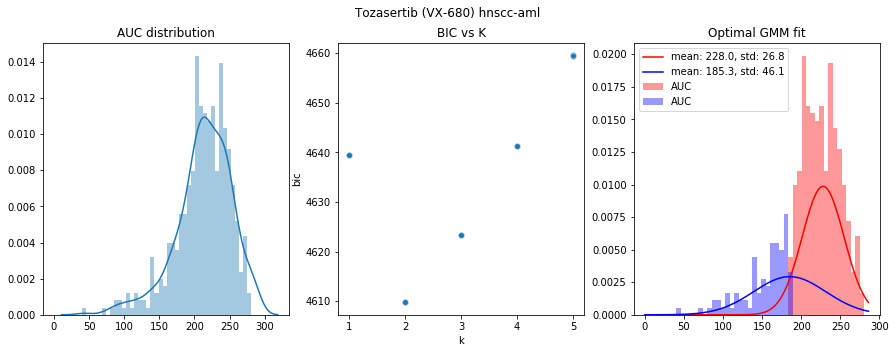

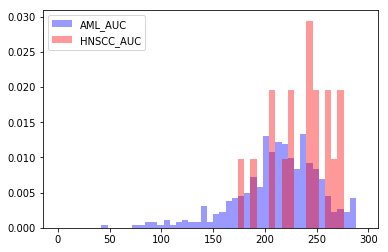

Running permutations...[100.00%]
16790
23.6609606026
Dasatinib permutation test p-value: 0.016790
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
BEZ235
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      423
Number of assays (aucs): 423
Optimal K: 1 [BIC=4549.3]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 155.1396563])
	Variances: array([ 2665.87541679])
Class counts: ['class 0: 423']


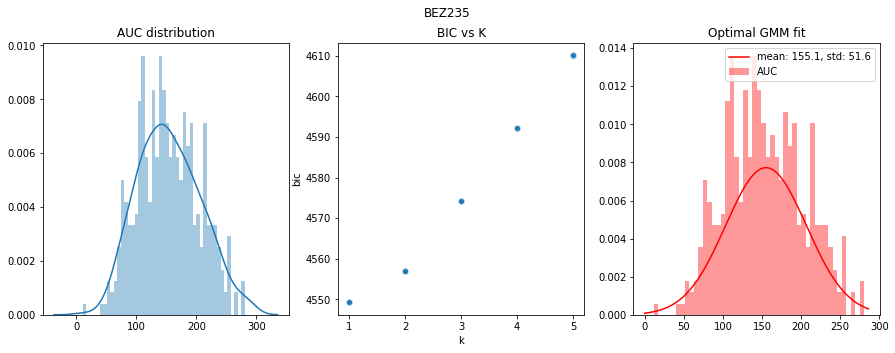

Number of assays (aucs): 17
Optimal K: 1 [BIC=179.9]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 126.14004924])
	Variances: array([ 1652.66669288])
Class counts: ['class 0: 17']


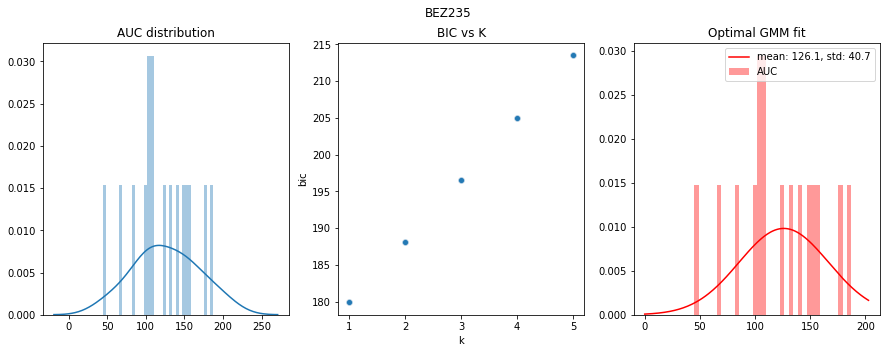

Number of assays (aucs): 440
Optimal K: 1 [BIC=4730.4]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 154.01921693])
	Variances: array([ 2657.965633])
Class counts: ['class 0: 440']


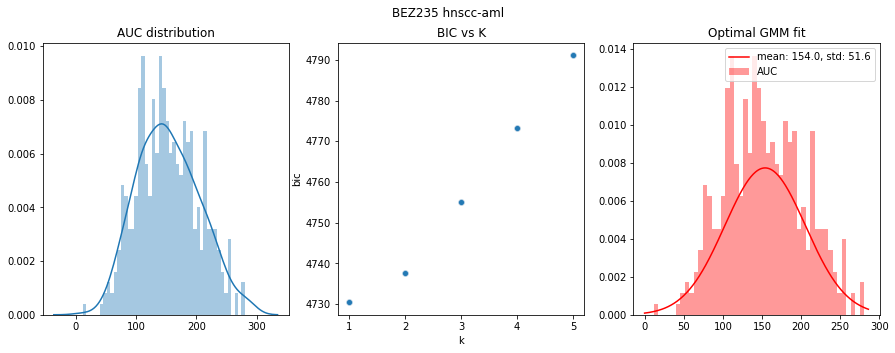

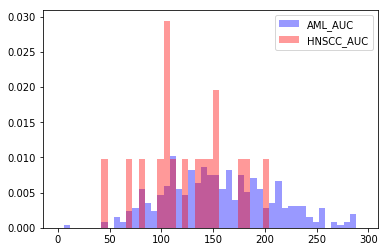

Running permutations...[100.00%]
22353
28.9996070556
Dasatinib permutation test p-value: 0.022353
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
A-674563
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      438
Number of assays (aucs): 438
Optimal K: 1 [BIC=4651.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 151.07041673])
	Variances: array([ 2329.23070046])
Class counts: ['class 0: 438']


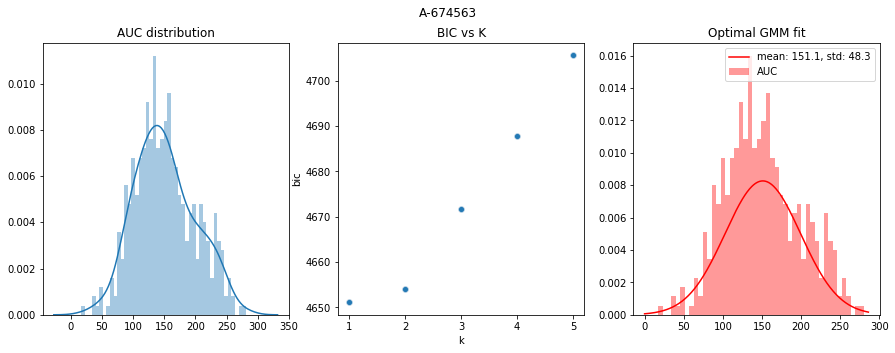

Number of assays (aucs): 17
Optimal K: 3 [BIC=175.6]
GMM fit:
	Mixture Weights: array([ 0.29981426,  0.05882353,  0.64136221])
	Means: array([ 166.80590253,   90.79631394,  223.38192797])
	Variances: array([  1.33839394e+02,   1.00000002e-03,   2.87875215e+02])
Class counts: ['class 0: 5', 'class 1: 1', 'class 2: 11']


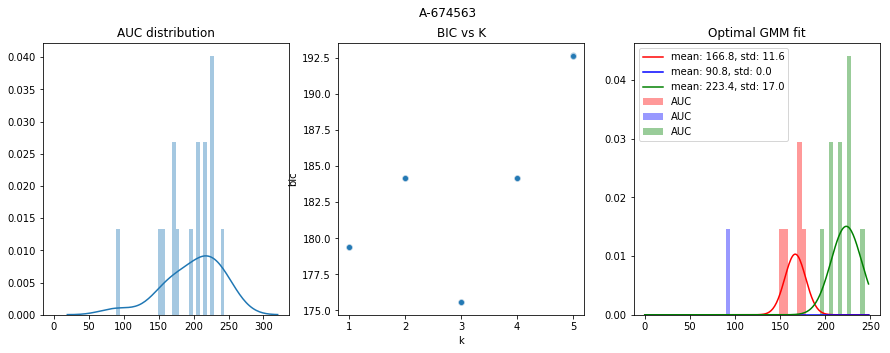

Number of assays (aucs): 455
Optimal K: 1 [BIC=4841.7]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 152.84701231])
	Variances: array([ 2383.50534535])
Class counts: ['class 0: 455']


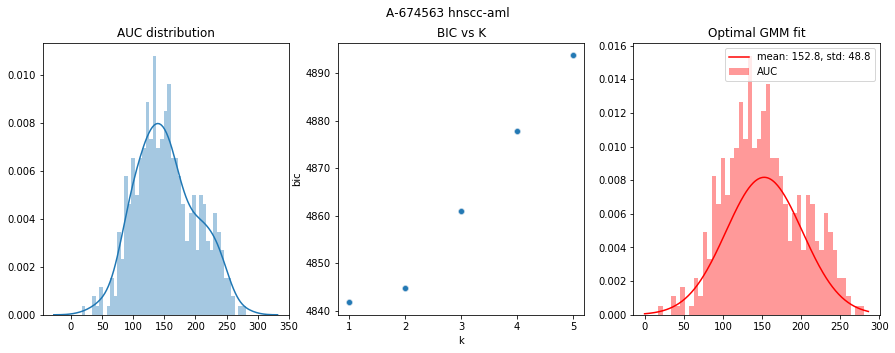

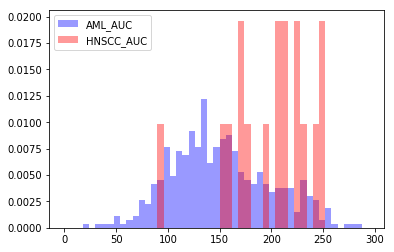

Running permutations...[100.00%]
63
47.550058023
Dasatinib permutation test p-value: 0.000063
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
17-AAG (Tanespimycin)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      422
Number of assays (aucs): 422
Optimal K: 1 [BIC=4443.6]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 154.50949899])
	Variances: array([ 2128.91559614])
Class counts: ['class 0: 422']


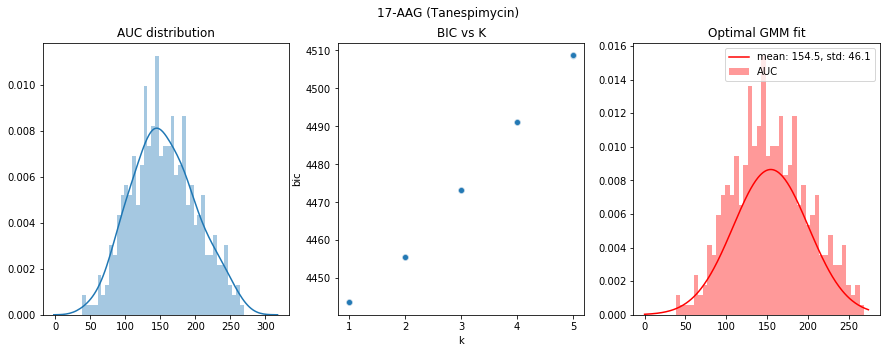

Number of assays (aucs): 17
Optimal K: 1 [BIC=187.5]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 142.10263706])
	Variances: array([ 2593.17199568])
Class counts: ['class 0: 17']


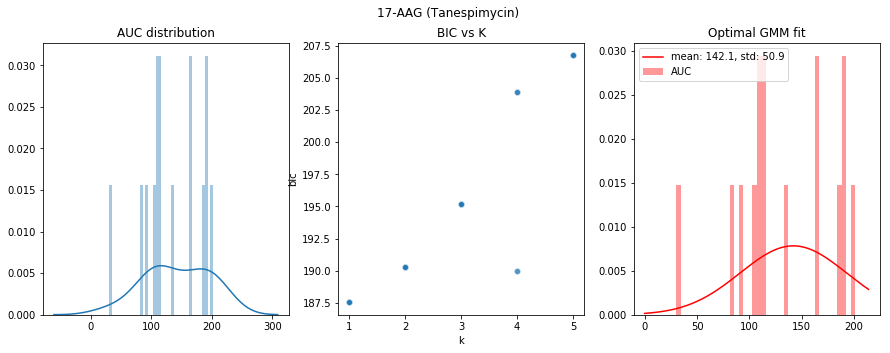

Number of assays (aucs): 439
Optimal K: 1 [BIC=4627.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 154.02905103])
	Variances: array([ 2152.62365561])
Class counts: ['class 0: 439']


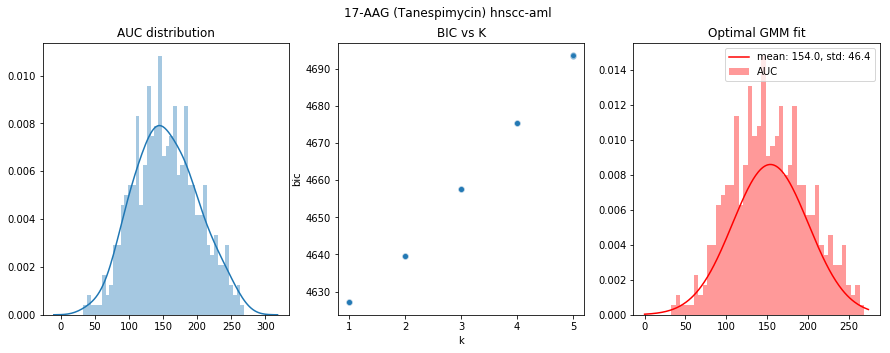

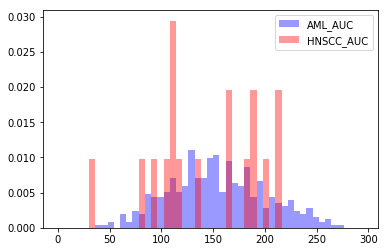

Running permutations...[100.00%]
280930
12.4068619348
Dasatinib permutation test p-value: 0.280930
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Elesclomol
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      401
Number of assays (aucs): 401
Optimal K: 3 [BIC=4037.7]
GMM fit:
	Mixture Weights: array([ 0.39585498,  0.09239963,  0.51174539])
	Means: array([  66.66850544,  203.44968902,   26.350298  ])
	Variances: array([  612.43965939,  2510.66009017,   166.22601469])
Class counts: ['class 0: 144', 'class 1: 36', 'class 2: 221']


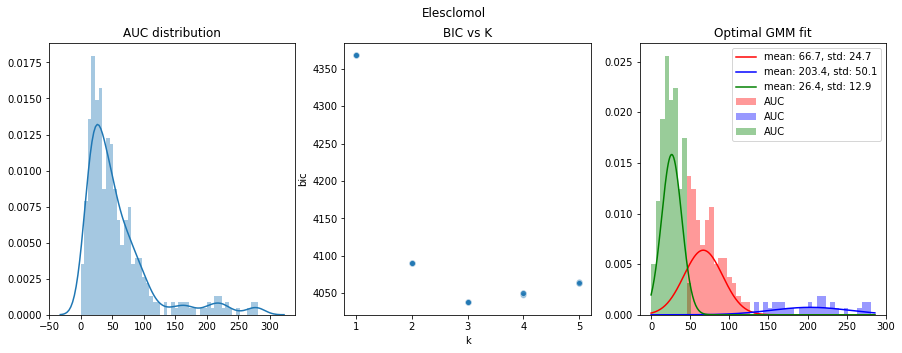

Number of assays (aucs): 17
Optimal K: 1 [BIC=193.6]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 169.47474365])
	Variances: array([ 3705.46371316])
Class counts: ['class 0: 17']


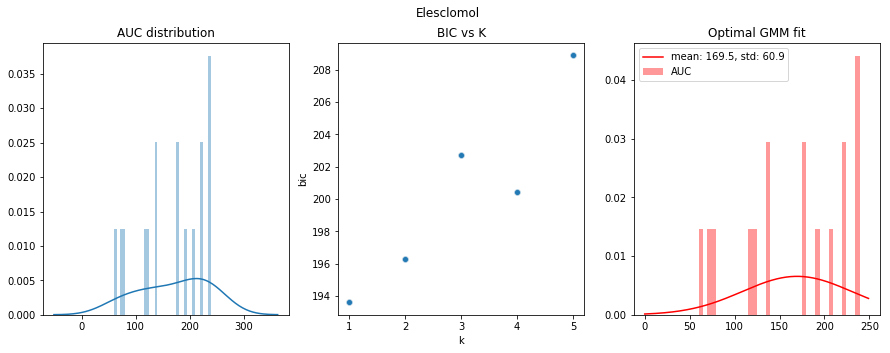

Number of assays (aucs): 418
Optimal K: 3 [BIC=4273.2]
GMM fit:
	Mixture Weights: array([ 0.49958492,  0.11522109,  0.38519398])
	Means: array([  26.80930943,  204.40916182,   68.10812667])
	Variances: array([  174.72590117,  2172.78306839,   663.39530539])
Class counts: ['class 0: 223', 'class 1: 48', 'class 2: 147']


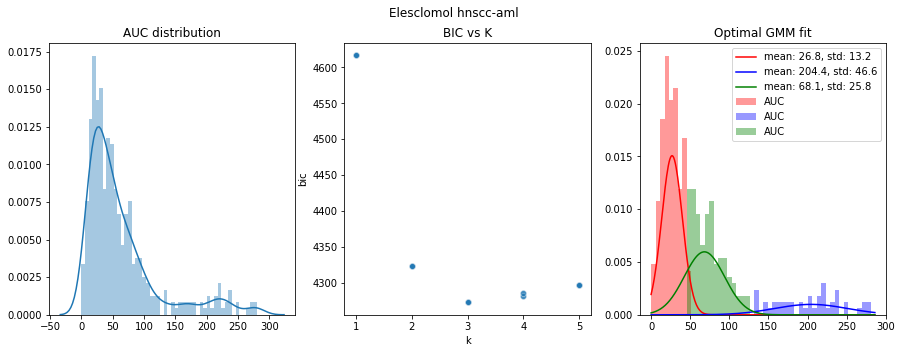

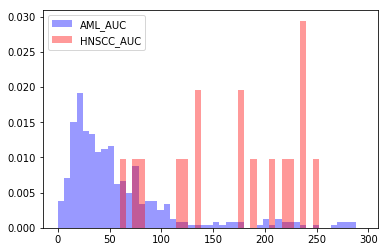

Running permutations...[33.60%]

KeyboardInterrupt: 

In [320]:
for inhib in shared_drugs: 
    aml_ = aml_aucs[aml_aucs.inhibitor == inhib].drop_duplicates().auc.values.reshape(-1,1)
    hnscc_ = 100*HNSCC_all[HNSCC_all.inhibitor == inhib].auc.drop_duplicates().values.reshape(-1,1) #hnscc is weighted by 1/100
    
    if aml_.shape[0] + hnscc_.shape[0] > 300: 
        test_distribution_similarity(aml_, hnscc_, inhib=inhib, perms=1e6)

In [ ]:
AML_Dasatinib = aml_aucs[aml_aucs['inhibitor'] == 'Sorafenib']
print('Number of AML Sorafenib assays: %d' %len(AML_Dasatinib))
AML_Dasatinib.head()

In [ ]:
HNSCC_Dasatinib = HNSCC_auc[HNSCC_auc['inhibitor'] == 'Sorafenib'].drop_duplicates()
print('Number of HNSCC Sorafenib assays: %d' %len(HNSCC_Dasatinib))
HNSCC_Dasatinib.head()

In [ ]:
print('------------------------------------------------')
print('Inhibitor:  %s' %'AML_Dasatinib')
print('------------------------------------------------')
aml_= AML_Dasatinib.auc.values.reshape(-1,1)
c = test_multimodal_fits(aml_, ntests=10, kmax=6, inhib=inhib, plot=True)

print('------------------------------------------------')
print('Inhibitor:  %s' %'HNSCC_Dasatinib')
print('------------------------------------------------')
hnscc_=100*HNSCC_Dasatinib.auc.values.reshape(-1,1)
c = test_multimodal_fits(hnscc_, ntests=10, kmax=6, inhib=inhib, plot=True)

In [ ]:
nbins=50
bin_ = np.arange(0,300,300/nbins)

plt.figure()
plt.hist(aml_,color='blue',label='AML_AUC',normed=True,alpha=0.4,bins=bin_)
plt.hist(hnscc_,color='red',label='HNSCC_AUC',normed=True,alpha=0.4,bins=bin_)
plt.legend()
plt.show()

In [ ]:
pval = permutation_test(aml_, hnscc_, n=1e6, verbose=True, return_prob=True)

print('Dasatinib permutation test p-value: %f' %pval)

# Drug response associated mutations 



In [ ]:
aml_var_all = pd.read_csv('./../data/vizome_beatAML_variants.csv', skiprows=[0,1,2])
#[aml_var_all.tumor_only == True]
aml_var = aml_var_all.dropna()[['sample_id', 'gene', 'chr','start','end','ref','alt','variant','sift']]

aml_var = aml_var.rename(columns={'sample_id':'lab_id'})

print(aml_var.head())

print(aml_var[['chr','start','end','ref','alt']].head())

print('Number of genes mutated: %d' %len(aml_var.gene.unique()))
print('Number of unique mutations: %d' %aml_var[['chr','start','end','ref','alt']].drop_duplicates().shape[0])

mut_cnt = aml_var.groupby('gene').count()['lab_id'].sort_values()
mult_patients = mut_cnt.index[mut_cnt > 20]
#aml_variants = aml_var[aml_var['lab_id'].isin(mult_patients)]

shared_mutations = [x for x in mult_patients]
print(shared_mutations)
print(aml_var.groupby('gene').count()['lab_id'].sort_values())

aml_var = aml_var[aml_var['gene'].isin(shared_mutations)]

aml_var.head()

In [ ]:
# convert variants to matrix format 

genes = pd.Series( aml_var.gene.unique() )

res = []
for lab_id in aml_var.lab_id.unique(): 
    D = aml_var[aml_var['lab_id'] == lab_id]
    x = genes.isin( D['gene'] ).tolist()
    res.append( [lab_id] + [str(int(xx)) for xx in x] )

res = pd.DataFrame( res, columns=['lab_id'] + genes.tolist() )

res.head()

MAT_VAR = res 

print('matrix variant shape: %s' %str(res.shape))
print(MAT_VAR.head())

In [ ]:
print( aml_aucs.head() )

aml_aucs['lab_id']=aml_aucs['lab_id'].astype(str)
MAT_VAR['lab_id']=MAT_VAR['lab_id'].astype(str)

aml_auc_w_var = aml_aucs.merge(right=MAT_VAR, how='inner', on=['lab_id'])
aml_auc_w_var.head(5)

In [ ]:
Dasatinib = aml_auc_w_var[aml_auc_w_var['inhibitor'] == 'Dasatinib']

print('Dasatinib auc and variants shape: %s' %str(Dasatinib.shape))

aucs = Dasatinib.auc.values.reshape(-1,1)
X = Dasatinib[genes]
Y = test_multimodal_fits(aucs, inhib='Dasatinib', override_k=2)

X_embedded = TSNE(n_components=2).fit_transform(X)
df = pd.DataFrame( {'x1':X_embedded[:,0], 'x2':X_embedded[:,1], 'label':Y} )

plt.figure() 
sbn.scatterplot(x='x1', y='x2', hue='label', data=df)
plt.show()

In [ ]:
reg = ElasticNet().fit(X, Y)

yhat = reg.predict(X)

pred = (yhat > 0.5)*1

acc = sum([a == b for a,b in zip(pred, Y)]*1) / len(Y)
print('Elastic Net accuracy: %.2f' %acc)

fpr, tpr, thresholds = metrics.roc_curve(Y, yhat, pos_label=1)
EN_auc = metrics.auc(fpr, tpr)
print('Elastic Net AUC: %.2f' %EN_auc)

plt.figure()
plt.plot(fpr,tpr,'r--')
plt.show()



logit = LogisticRegression().fit(X,Y)

yhat = logit.predict(X)
pred = (yhat > 0.5)*1
print(pred)

acc = sum([a == b for a,b in zip(pred, Y)]*1) / len(Y)
print('Logistic Regression accuracy: %.2f' %acc)

fpr, tpr, thresholds = metrics.roc_curve(Y, yhat, pos_label=1)
EN_auc = metrics.auc(fpr, tpr)
print('Logistic Regression AUC: %.2f' %EN_auc)

plt.figure()
plt.plot(fpr,tpr,'r--')
plt.show()

print('---------------------------------------------------')
print('STATSMODEL LOGIT')
print('---------------------------------------------------')

X2 = X.values.astype(int)
logit_sm = sm.Logit(Y, sm.add_constant(X2)).fit(method='lbfgs', maxiter=500)
yhat = logit_sm.predict(sm.add_constant(X2))

cutoff = 0.9
pred = (yhat > cutoff)*1

acc = sum([a == b for a,b in zip(pred, Y)]*1) / len(Y)
print('Logistic Regression accuracy: %.2f' %acc)

fpr, tpr, thresholds = metrics.roc_curve(Y, yhat, pos_label=1)
EN_auc = metrics.auc(fpr, tpr)
print('Logistic Regression AUC: %.2f' %EN_auc)

plt.figure()
plt.plot(fpr,tpr,'r--')
plt.show()

print( logit_sm.summary() )

#print(yhat)

#build_RF_variant_model(X,Y)